# predicti_SOI

** 数据集 ** 


- 两列数据的气象序列, 一列是时间，一列是南方涛动指数
- 南方涛动（Southern Oscillation）是热带环流年际变化最突出、最重要的一个现象。主要指发生在东南太平洋与印度洋及印尼地区之间的反相气压振动。
- 目的：通过以前的南方涛动指数（SOI），去预测后面

** 导入模块 **

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

Using TensorFlow backend.
/home/htfeng/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 设置参数

In [2]:
seq_len = 22
d = 0.2
shape = [1, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

## 导入数据

In [3]:
df = pd.read_csv('../DATA/soi.csv')
df = df.set_index('time')

In [4]:
df.head()

,SOI
time,
1951.0417,1.5
1951.1250,0.9
1951.2083,-0.1
1951.2917,-0.3
1951.3750,-0.7


**  标准化 **

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
df['SOI'] = min_max_scaler.fit_transform(df.SOI.values.reshape(-1,1))

In [6]:
df.head()

,SOI
time,
1951.0417,0.784615
1951.1250,0.692308
1951.2083,0.538462
1951.2917,0.507692
1951.3750,0.446154


**画图**

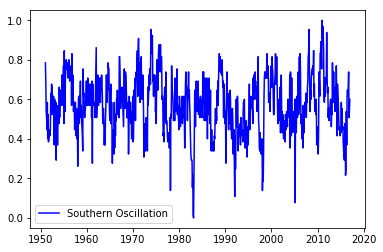

In [7]:
plt.plot(df.SOI, color='blue', label='Southern Oscillation')
plt.legend(loc='best')
plt.show()

** 数据预处理 ** 

In [28]:
amount_of_features = len(df.columns)
data = df.as_matrix() 
sequence_length = seq_len + 1 # index starting from 0
result = []

In [29]:
for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

In [30]:
result = np.array(result)

** 测试集和验证集 **

In [32]:
row = round(0.9 * result.shape[0]) # 90% split
    
train = result[:int(row), :] # 90% date
X_train = train[:, :-1] # all data until day m
y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

X_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1] 

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  


In [33]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(692, 22, 1)

In [36]:
y_train.shape[0]

692

## 构建神经网络

In [41]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [42]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________________________________________________


** 模型训练 **

In [43]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 622 samples, validate on 70 samples
Epoch 1/300
622/622 [==============================] - 5s 7ms/step - loss: 0.3424 - acc: 0.0016 - val_loss: 0.3457 - val_acc: 0.0000e+00
Epoch 2/300
622/622 [==============================] - 1s 1ms/step - loss: 0.3264 - acc: 0.0016 - val_loss: 0.3164 - val_acc: 0.0000e+00
Epoch 3/300
622/622 [==============================] - 1s 1ms/step - loss: 0.2957 - acc: 0.0016 - val_loss: 0.2479 - val_acc: 0.0000e+00
Epoch 4/300
622/622 [==============================] - 1s 1ms/step - loss: 0.2247 - acc: 0.0016 - val_loss: 0.1156 - val_acc: 0.0000e+00
Epoch 5/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0980 - acc: 0.0016 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 6/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0374 - val_acc: 0.0000e+00
Epoch 7/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0425 - acc: 0.0000e+00 - val_loss: 0.0395 - val_acc:

Epoch 116/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0205 - acc: 0.0000e+00 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 117/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 118/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 119/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0208 - acc: 0.0000e+00 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 120/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0200 - acc: 0.0016 - val_loss: 0.0205 - val_acc: 0.0000e+00
Epoch 121/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0198 - acc: 0.0000e+00 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 122/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0214 - acc: 0.0000e+00 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epo

622/622 [==============================] - 1s 1ms/step - loss: 0.0161 - acc: 0.0016 - val_loss: 0.0173 - val_acc: 0.0000e+00
Epoch 175/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0156 - acc: 0.0016 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 176/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0152 - acc: 0.0016 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 177/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0161 - acc: 0.0016 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 178/300
622/622 [==============================] - 1s 2ms/step - loss: 0.0161 - acc: 0.0016 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 179/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0155 - acc: 0.0016 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 180/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0156 - acc: 0.0016 - val_loss: 0.0170 - val_acc: 0.0000e+00
Epoch 181/300
622/622 [==================

622/622 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.0016 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 234/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0137 - acc: 0.0016 - val_loss: 0.0163 - val_acc: 0.0000e+00
Epoch 235/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0129 - acc: 0.0016 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 236/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.0016 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 237/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.0016 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 238/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0131 - acc: 0.0016 - val_loss: 0.0161 - val_acc: 0.0000e+00
Epoch 239/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0130 - acc: 0.0016 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 240/300
622/622 [==================

622/622 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.0016 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 293/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0134 - acc: 0.0016 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 294/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0130 - acc: 0.0016 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 295/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0131 - acc: 0.0016 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 296/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0125 - acc: 0.0016 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 297/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0128 - acc: 0.0016 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 298/300
622/622 [==============================] - 1s 1ms/step - loss: 0.0122 - acc: 0.0016 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 299/300
622/622 [==================

** 查看成绩 **

In [44]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [45]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.01199 MSE (0.11 RMSE)
Test Score: 0.01360 MSE (0.12 RMSE)


(0.011987031448223343, 0.013604858986936606)

** 模型预测 **

In [46]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [49]:
p = percentage_difference(model, X_test, y_test)

## 画出预测

/home/htfeng/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


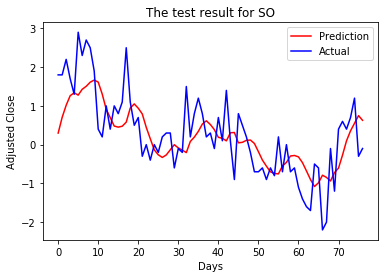

In [53]:
import matplotlib.pyplot as plt2
newp = min_max_scaler.inverse_transform(p)
newy_test = min_max_scaler.inverse_transform(y_test)
plt2.plot(newp, color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.title('The test result for {}'.format(df.SOI.name))
plt2.xlabel('Days')
plt2.ylabel('Adjusted Close')
plt2.show()

In [58]:
newp[:10]

array([[ 0.29806727],
       [ 0.70551831],
       [ 1.01686919],
       [ 1.26270843],
       [ 1.33758783],
       [ 1.27755749],
       [ 1.42857039],
       [ 1.50486743],
       [ 1.61121464],
       [ 1.66706276]], dtype=float32)

In [59]:
newy_test[:10]

array([ 1.8,  1.8,  2.2,  1.7,  1.3,  2.9,  2.3,  2.7,  2.5,  1.9])